In [1]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==1.5.0
# !pip install torchvision==0.6.0
# !pip install torchtext==0.3.1
# !pip install numpy==1.21.6
# !pip install matplotlib==3.2.2
# !pip install Pillow==7.1.2
# !pip install opencv-python==4.6.0

# 第10章 torch.optimパッケージ

# 10.1 最適化関数の選択

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Mnist画像分類での例
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False,
                                          num_workers=2)

In [4]:
#ネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

num_epochs = 10
optimizer = None
scheduler = None

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [6]:
#最適化関数とスケジューラを可変で渡せる関数
def main(net, optimizer, scheduler):
    criterion = nn.CrossEntropyLoss()
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        #train
        net.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            loss.backward()
            #パラメータ更新
            optimizer.step()
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader.dataset)

        #val
        net.eval()
        with torch.no_grad():
            for images, labels in test_loader:        
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader)
        avg_val_acc = val_acc / len(test_loader.dataset)

        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr: {learning_rate}'.
               format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]['lr']))
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        if scheduler != None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:            
                scheduler.step()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

# SGD


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 0.7641, val_loss: 0.1249, val_acc: 0.9632, lr: 0.01
Epoch [2/10], Loss: 0.2930, val_loss: 0.0792, val_acc: 0.9738, lr: 0.01
Epoch [3/10], Loss: 0.2303, val_loss: 0.0677, val_acc: 0.9778, lr: 0.01
Epoch [4/10], Loss: 0.1979, val_loss: 0.0541, val_acc: 0.9826, lr: 0.01
Epoch [5/10], Loss: 0.1817, val_loss: 0.0538, val_acc: 0.9837, lr: 0.01
Epoch [6/10], Loss: 0.1705, val_loss: 0.0476, val_acc: 0.9851, lr: 0.01
Epoch [7/10], Loss: 0.1628, val_loss: 0.0473, val_acc: 0.9844, lr: 0.01
Epoch [8/10], Loss: 0.1568, val_loss: 0.0435, val_acc: 0.9858, lr: 0.01
Epoch [9/10], Loss: 0.1481, val_loss: 0.0434, val_acc: 0.9862, lr: 0.01
Epoch [10/10], Loss: 0.1452, val_loss: 0.0403, val_acc: 0.9866, lr: 0.01


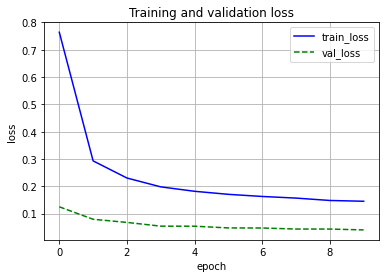

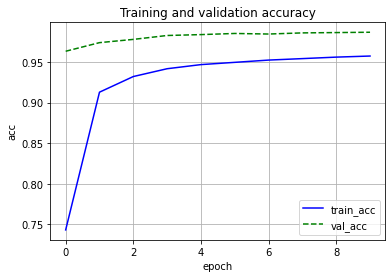

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adadelta


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.Adadelta(net.parameters(), rho=0.9)
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 0.4517, val_loss: 0.0915, val_acc: 0.9726, lr: 1.0
Epoch [2/10], Loss: 0.2281, val_loss: 0.0682, val_acc: 0.9799, lr: 1.0
Epoch [3/10], Loss: 0.1873, val_loss: 0.0600, val_acc: 0.9799, lr: 1.0
Epoch [4/10], Loss: 0.1767, val_loss: 0.0571, val_acc: 0.9831, lr: 1.0
Epoch [5/10], Loss: 0.1643, val_loss: 0.0537, val_acc: 0.9849, lr: 1.0
Epoch [6/10], Loss: 0.1597, val_loss: 0.0528, val_acc: 0.9849, lr: 1.0
Epoch [7/10], Loss: 0.1545, val_loss: 0.0523, val_acc: 0.9835, lr: 1.0
Epoch [8/10], Loss: 0.1505, val_loss: 0.0489, val_acc: 0.9854, lr: 1.0
Epoch [9/10], Loss: 0.1506, val_loss: 0.0479, val_acc: 0.9852, lr: 1.0
Epoch [10/10], Loss: 0.1421, val_loss: 0.0682, val_acc: 0.9839, lr: 1.0


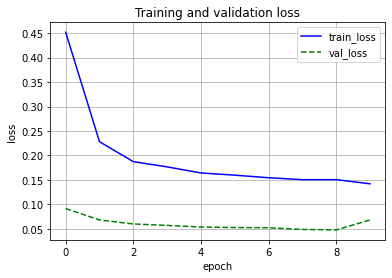

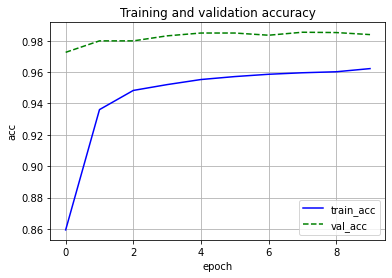

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adagrad


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.Adagrad(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 0.5236, val_loss: 0.1454, val_acc: 0.9574, lr: 0.01
Epoch [2/10], Loss: 0.3223, val_loss: 0.1186, val_acc: 0.9635, lr: 0.01
Epoch [3/10], Loss: 0.2862, val_loss: 0.1041, val_acc: 0.9672, lr: 0.01
Epoch [4/10], Loss: 0.2624, val_loss: 0.0942, val_acc: 0.9709, lr: 0.01
Epoch [5/10], Loss: 0.2481, val_loss: 0.0902, val_acc: 0.9718, lr: 0.01
Epoch [6/10], Loss: 0.2413, val_loss: 0.0858, val_acc: 0.9736, lr: 0.01
Epoch [7/10], Loss: 0.2295, val_loss: 0.0810, val_acc: 0.9746, lr: 0.01
Epoch [8/10], Loss: 0.2251, val_loss: 0.0798, val_acc: 0.9742, lr: 0.01
Epoch [9/10], Loss: 0.2175, val_loss: 0.0759, val_acc: 0.9750, lr: 0.01
Epoch [10/10], Loss: 0.2144, val_loss: 0.0754, val_acc: 0.9770, lr: 0.01


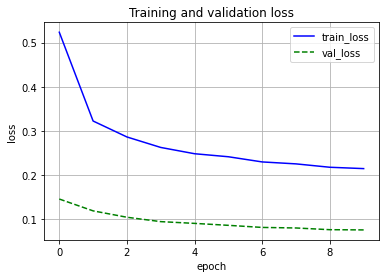

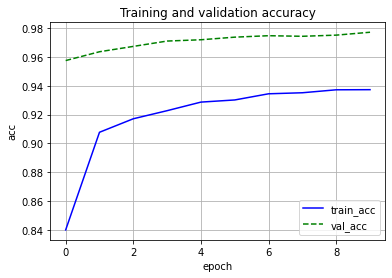

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adam


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.Adam(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 0.6571, val_loss: 0.1319, val_acc: 0.9602, lr: 0.001
Epoch [2/10], Loss: 0.2957, val_loss: 0.0863, val_acc: 0.9739, lr: 0.001
Epoch [3/10], Loss: 0.2406, val_loss: 0.0694, val_acc: 0.9786, lr: 0.001
Epoch [4/10], Loss: 0.2078, val_loss: 0.0598, val_acc: 0.9799, lr: 0.001
Epoch [5/10], Loss: 0.1902, val_loss: 0.0552, val_acc: 0.9829, lr: 0.001
Epoch [6/10], Loss: 0.1800, val_loss: 0.0505, val_acc: 0.9837, lr: 0.001
Epoch [7/10], Loss: 0.1688, val_loss: 0.0473, val_acc: 0.9858, lr: 0.001
Epoch [8/10], Loss: 0.1579, val_loss: 0.0444, val_acc: 0.9862, lr: 0.001
Epoch [9/10], Loss: 0.1570, val_loss: 0.0426, val_acc: 0.9864, lr: 0.001
Epoch [10/10], Loss: 0.1501, val_loss: 0.0426, val_acc: 0.9866, lr: 0.001


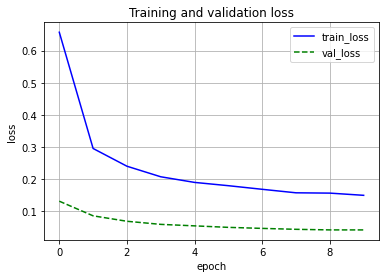

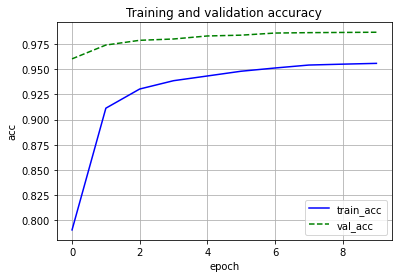

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## RMSprop


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.RMSprop(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 0.6744, val_loss: 0.1177, val_acc: 0.9648, lr: 0.01
Epoch [2/10], Loss: 0.3565, val_loss: 0.1010, val_acc: 0.9692, lr: 0.01
Epoch [3/10], Loss: 0.3230, val_loss: 0.0917, val_acc: 0.9725, lr: 0.01
Epoch [4/10], Loss: 0.3202, val_loss: 0.1055, val_acc: 0.9711, lr: 0.01
Epoch [5/10], Loss: 0.3088, val_loss: 0.0868, val_acc: 0.9729, lr: 0.01
Epoch [6/10], Loss: 0.3099, val_loss: 0.0933, val_acc: 0.9697, lr: 0.01
Epoch [7/10], Loss: 0.3006, val_loss: 0.1140, val_acc: 0.9661, lr: 0.01
Epoch [8/10], Loss: 0.3044, val_loss: 0.0891, val_acc: 0.9736, lr: 0.01
Epoch [9/10], Loss: 0.3041, val_loss: 0.0923, val_acc: 0.9737, lr: 0.01
Epoch [10/10], Loss: 0.3049, val_loss: 0.0881, val_acc: 0.9759, lr: 0.01


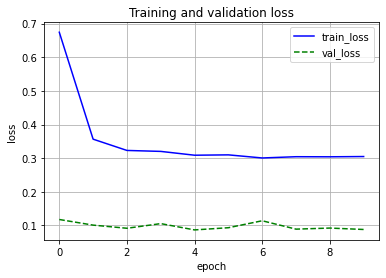

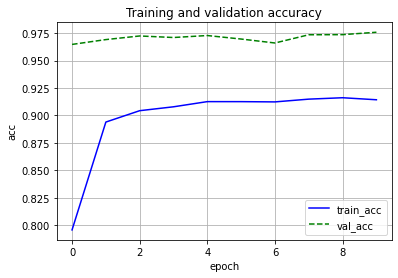

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

# 10.3 学習率を調整する




In [17]:
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

## LambdaLR


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
lambda1 = lambda epoch: 1.0 / num_epochs
scheduler = LambdaLR(opt, lr_lambda=[lambda1])
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 2.2978, val_loss: 2.2876, val_acc: 0.1367, lr: 0.001
Epoch [2/10], Loss: 2.2756, val_loss: 2.2429, val_acc: 0.3559, lr: 0.001
Epoch [3/10], Loss: 2.1799, val_loss: 1.9796, val_acc: 0.4493, lr: 0.001
Epoch [4/10], Loss: 1.8312, val_loss: 1.3683, val_acc: 0.6415, lr: 0.001
Epoch [5/10], Loss: 1.3798, val_loss: 0.8496, val_acc: 0.7827, lr: 0.001
Epoch [6/10], Loss: 1.0546, val_loss: 0.6049, val_acc: 0.8334, lr: 0.001
Epoch [7/10], Loss: 0.8827, val_loss: 0.4971, val_acc: 0.8583, lr: 0.001
Epoch [8/10], Loss: 0.7864, val_loss: 0.4356, val_acc: 0.8783, lr: 0.001
Epoch [9/10], Loss: 0.7210, val_loss: 0.3919, val_acc: 0.8887, lr: 0.001
Epoch [10/10], Loss: 0.6743, val_loss: 0.3573, val_acc: 0.8985, lr: 0.001


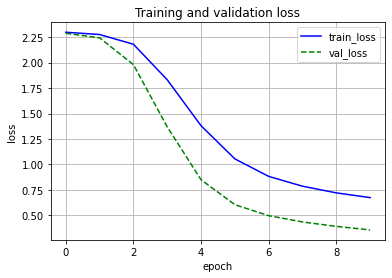

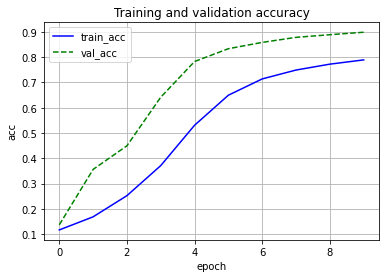

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## StepLR


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
#2エポックごとに0.1を掛ける。
scheduler = StepLR(opt, step_size=2, gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 1.3500, val_loss: 0.3392, val_acc: 0.8995, lr: 0.01
Epoch [2/10], Loss: 0.5311, val_loss: 0.1954, val_acc: 0.9396, lr: 0.01
Epoch [3/10], Loss: 0.4088, val_loss: 0.1459, val_acc: 0.9552, lr: 0.01
Epoch [4/10], Loss: 0.3495, val_loss: 0.1414, val_acc: 0.9564, lr: 0.001
Epoch [5/10], Loss: 0.3416, val_loss: 0.1363, val_acc: 0.9576, lr: 0.001
Epoch [6/10], Loss: 0.3345, val_loss: 0.1357, val_acc: 0.9574, lr: 0.00010000000000000002
Epoch [7/10], Loss: 0.3350, val_loss: 0.1354, val_acc: 0.9579, lr: 0.00010000000000000002
Epoch [8/10], Loss: 0.3337, val_loss: 0.1353, val_acc: 0.9580, lr: 1.0000000000000003e-05
Epoch [9/10], Loss: 0.3324, val_loss: 0.1353, val_acc: 0.9580, lr: 1.0000000000000003e-05
Epoch [10/10], Loss: 0.3368, val_loss: 0.1353, val_acc: 0.9581, lr: 1.0000000000000002e-06


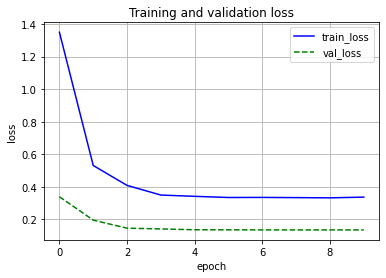

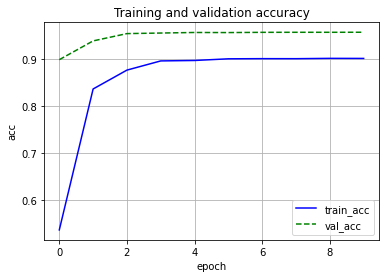

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## MultiStepLR



In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
#5エポックとに10エポックでガンマを掛ける。
scheduler = MultiStepLR(opt, milestones=[5,10], gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 1.2773, val_loss: 0.3318, val_acc: 0.9086, lr: 0.01
Epoch [2/10], Loss: 0.5143, val_loss: 0.1964, val_acc: 0.9403, lr: 0.01
Epoch [3/10], Loss: 0.3925, val_loss: 0.1466, val_acc: 0.9538, lr: 0.01
Epoch [4/10], Loss: 0.3387, val_loss: 0.1200, val_acc: 0.9615, lr: 0.01
Epoch [5/10], Loss: 0.2971, val_loss: 0.1055, val_acc: 0.9670, lr: 0.01
Epoch [6/10], Loss: 0.2727, val_loss: 0.0915, val_acc: 0.9706, lr: 0.01
Epoch [7/10], Loss: 0.2511, val_loss: 0.0890, val_acc: 0.9717, lr: 0.001
Epoch [8/10], Loss: 0.2417, val_loss: 0.0877, val_acc: 0.9715, lr: 0.001
Epoch [9/10], Loss: 0.2385, val_loss: 0.0865, val_acc: 0.9724, lr: 0.001
Epoch [10/10], Loss: 0.2347, val_loss: 0.0852, val_acc: 0.9731, lr: 0.001


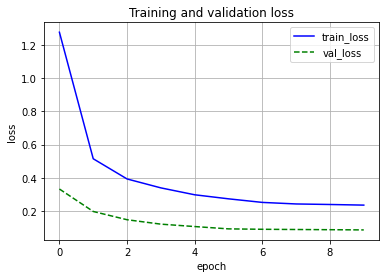

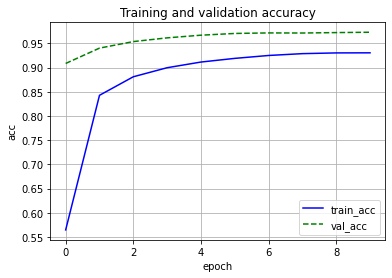

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ExponentialLR


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = ExponentialLR(opt, gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/10], Loss: 1.2201, val_loss: 0.3125, val_acc: 0.9099, lr: 0.01
Epoch [2/10], Loss: 0.5129, val_loss: 0.2007, val_acc: 0.9407, lr: 0.01
Epoch [3/10], Loss: 0.4122, val_loss: 0.1821, val_acc: 0.9445, lr: 0.001
Epoch [4/10], Loss: 0.4052, val_loss: 0.1815, val_acc: 0.9454, lr: 0.00010000000000000002
Epoch [5/10], Loss: 0.4040, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000003e-05
Epoch [6/10], Loss: 0.4016, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000002e-06
Epoch [7/10], Loss: 0.4054, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000002e-07
Epoch [8/10], Loss: 0.4029, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000004e-08
Epoch [9/10], Loss: 0.4057, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000005e-09
Epoch [10/10], Loss: 0.4051, val_loss: 0.1814, val_acc: 0.9455, lr: 1.0000000000000006e-10


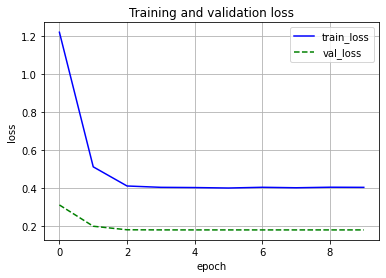

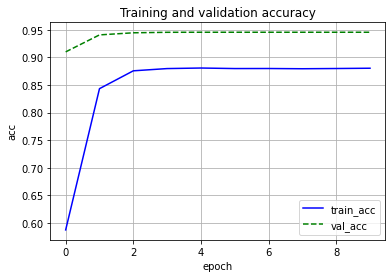

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ReduceLROnPlateau


In [30]:
num_epochs = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = ReduceLROnPlateau(opt, 'min', patience=2)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, opt, scheduler)

Epoch [1/12], Loss: 1.2546, val_loss: 0.3037, val_acc: 0.9161, lr: 0.01
Epoch [2/12], Loss: 0.4879, val_loss: 0.1812, val_acc: 0.9459, lr: 0.01
Epoch [3/12], Loss: 0.3768, val_loss: 0.1427, val_acc: 0.9573, lr: 0.01
Epoch [4/12], Loss: 0.3277, val_loss: 0.1189, val_acc: 0.9637, lr: 0.01
Epoch [5/12], Loss: 0.2956, val_loss: 0.1128, val_acc: 0.9665, lr: 0.001
Epoch [6/12], Loss: 0.2859, val_loss: 0.1109, val_acc: 0.9666, lr: 0.001
Epoch [7/12], Loss: 0.2852, val_loss: 0.1102, val_acc: 0.9663, lr: 0.001
Epoch [8/12], Loss: 0.2813, val_loss: 0.1097, val_acc: 0.9662, lr: 0.0001
Epoch [9/12], Loss: 0.2823, val_loss: 0.1096, val_acc: 0.9662, lr: 0.0001
Epoch [10/12], Loss: 0.2794, val_loss: 0.1093, val_acc: 0.9667, lr: 0.0001
Epoch [11/12], Loss: 0.2831, val_loss: 0.1093, val_acc: 0.9666, lr: 1e-05
Epoch [12/12], Loss: 0.2793, val_loss: 0.1093, val_acc: 0.9667, lr: 1e-05


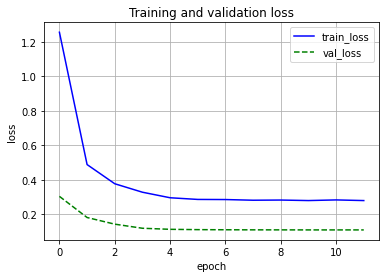

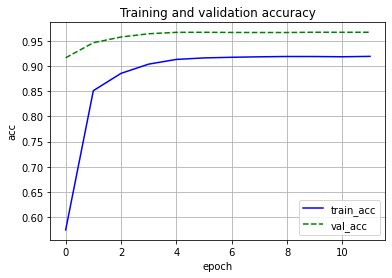

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()